# Import Libraries

In [229]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns


# Data Preproscessing

In [230]:
# Load Data
gold_data = pd.read_csv('data/gold_price_data.csv')
gold_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2015-10-02 00:00:00-04:00,1112.199951,1141.199951,1105.800049,1137.099976,323,0.0,0.0
1,2015-10-05 00:00:00-04:00,1137.099976,1141.699951,1132.500000,1138.099976,226,0.0,0.0
2,2015-10-06 00:00:00-04:00,1136.300049,1150.000000,1136.300049,1146.800049,145,0.0,0.0
3,2015-10-07 00:00:00-04:00,1147.599976,1152.900024,1143.000000,1149.000000,104,0.0,0.0
4,2015-10-08 00:00:00-04:00,1142.699951,1146.699951,1138.699951,1144.699951,138,0.0,0.0


In [231]:
# Preprocess Data
# Create copy of data
preprocessed_data = gold_data.copy()

# drop unnecessary columns
preprocessed_data.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

# Set up tomorrow's close price
preprocessed_data['Tomorrow_Close'] = preprocessed_data['Close'].shift(-1)

# Moving Average
preprocessed_data['MA_2'] = preprocessed_data['Close'].rolling(window=2).mean()
preprocessed_data['MA_7'] = preprocessed_data['Close'].rolling(window=7).mean()
preprocessed_data['MA_30'] = preprocessed_data['Close'].rolling(window=30).mean()
preprocessed_data['MA_90'] = preprocessed_data['Close'].rolling(window=90).mean()
preprocessed_data['MA_365'] = preprocessed_data['Close'].rolling(window=365).mean()

# Trend
preprocessed_data['Trend_2'] = preprocessed_data['Close'].pct_change(periods=2)
preprocessed_data['Trend_7'] = preprocessed_data['Close'].pct_change(periods=7)
preprocessed_data['Trend_30'] = preprocessed_data['Close'].pct_change(periods=30)
preprocessed_data['Trend_90'] = preprocessed_data['Close'].pct_change(periods=90)
preprocessed_data['Trend_365'] = preprocessed_data['Close'].pct_change(periods=365)

#volatility
preprocessed_data['Volatility_7'] = preprocessed_data['Close'].rolling(window=7).std()
preprocessed_data['Volatility_30'] = preprocessed_data['Close'].rolling(window=30).std()
preprocessed_data['Volatility_90'] = preprocessed_data['Close'].rolling(window=90).std()
preprocessed_data['Volatility_180'] = preprocessed_data['Close'].rolling(window=180).std()
preprocessed_data['Volatility_365'] = preprocessed_data['Close'].rolling(window=365).std()


#RSI
def compute_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi
preprocessed_data['RSI_14'] = compute_rsi(preprocessed_data, window=14)
preprocessed_data['RSI_30'] = compute_rsi(preprocessed_data, window=30)
preprocessed_data['RSI_90'] = compute_rsi(preprocessed_data, window=90)
preprocessed_data['RSI_180'] = compute_rsi(preprocessed_data, window=180)
preprocessed_data['RSI_365'] = compute_rsi(preprocessed_data, window=365)

# MACD (Moving Average Convergence Divergence)
def compute_macd(data, fast_period=12, slow_period=26, signal_period=9):
    exp1 = data['Close'].ewm(span=fast_period, adjust=False).mean()
    exp2 = data['Close'].ewm(span=slow_period, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=signal_period, adjust=False).mean()
    histogram = macd - signal
    return macd, signal, histogram

preprocessed_data['MACD'], preprocessed_data['MACD_Signal'], preprocessed_data['MACD_Hist'] = compute_macd(preprocessed_data)

# Lagged Close Prices
preprocessed_data['Close_Lag_1'] = preprocessed_data['Close'].shift(1)
preprocessed_data['Close_Lag_2'] = preprocessed_data['Close'].shift(2)
preprocessed_data['Close_Lag_5'] = preprocessed_data['Close'].shift(5)

# Drop rows with NaN values
preprocessed_data.dropna(inplace=True)


In [232]:
# Set up target variables
preprocessed_data['Price Direction'] = (
            preprocessed_data['Tomorrow_Close'] > preprocessed_data['Close']
            ).astype(int)

preprocessed_data.dropna(inplace=True)
preprocessed_data

,Date,Open,High,Low,Close,Volume,Tomorrow_Close,MA_2,MA_7,MA_30,...,RSI_90,RSI_180,RSI_365,MACD,MACD_Signal,MACD_Hist,Close_Lag_1,Close_Lag_2,Close_Lag_5,Price Direction
365,2017-03-20 00:00:00-04:00,1229.300049,1234.400024,1229.300049,1233.599976,23,1246.099976,1231.700012,1213.571429,1228.909998,...,44.780585,46.961242,51.565898,-0.636707,-0.457684,-0.179023,1229.800049,1226.500000,1202.400024,1
366,2017-03-21 00:00:00-04:00,1226.400024,1246.099976,1226.400024,1246.099976,11,1249.300049,1239.849976,1220.057146,1229.446663,...,47.542730,47.114671,51.745991,1.478148,-0.070517,1.548665,1233.599976,1229.800049,1201.900024,1
367,2017-03-22 00:00:00-04:00,1247.900024,1249.500000,1247.699951,1249.300049,3,1246.900024,1247.700012,1226.757150,1229.950000,...,48.156085,47.432946,51.660027,3.373517,0.618289,2.755227,1246.099976,1233.599976,1200.099976,0
368,2017-03-23 00:00:00-04:00,1246.400024,1247.500000,1244.800049,1246.900024,16,1248.199951,1248.100037,1233.185721,1230.260002,...,48.038471,46.624064,51.585426,4.628593,1.420350,3.208243,1249.300049,1246.099976,1226.500000,1
369,2017-03-24 00:00:00-04:00,1248.000000,1248.300049,1247.599976,1248.199951,3,1255.400024,1247.549988,1240.057146,1230.696667,...,48.667792,45.875266,51.677744,5.662865,2.268853,3.394012,1246.900024,1249.300049,1229.800049,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2508,2025-09-25 00:00:00-04:00,3742.800049,3756.000000,3724.699951,3736.899902,1899,3775.300049,3734.500000,3712.471436,3544.493319,...,61.025261,60.154918,57.695805,82.261409,78.967636,3.293773,3732.100098,3780.600098,3643.699951,1
2509,2025-09-26 00:00:00-04:00,3775.300049,3775.300049,3775.300049,3775.300049,19308,3820.899902,3756.099976,3725.828578,3559.163322,...,60.804085,60.298530,57.759346,83.267500,79.827609,3.439891,3736.899902,3732.100098,3671.500000,1
2510,2025-09-29 00:00:00-04:00,3754.800049,3827.600098,3754.800049,3820.899902,8860,3840.800049,3798.099976,3751.142857,3575.326652,...,61.086067,60.454494,58.097900,86.744426,81.210973,5.533454,3775.300049,3736.899902,3740.699951,1
2511,2025-09-30 00:00:00-04:00,3827.500000,3865.500000,3793.399902,3840.800049,1611,3867.500000,3830.849976,3775.328578,3592.296655,...,61.870751,61.001678,58.141405,90.067449,82.982268,7.085181,3820.899902,3775.300049,3780.600098,1


In [233]:
# train-test split (time series split without random shuffling)
features = preprocessed_data.drop(columns=['Date', 'Tomorrow_Close', 'Price Direction'  ])
target_reg = preprocessed_data['Tomorrow_Close']
target_clf = preprocessed_data['Price Direction']
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(features):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train_reg, y_test_reg = target_reg.iloc[train_index], target_reg.iloc[test_index]
    y_train_clf, y_test_clf = target_clf.iloc[train_index], target_clf.iloc[test_index]
    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
print(f"Training set size: {X_train.shape}, Testing set size: {X_test.shape}")

Training set size: (1790, 31), Testing set size: (358, 31)


# Train Model

In [234]:
# Train Model
# Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=1000,
    max_depth=100,
    min_samples_split=10,
    min_samples_leaf=10,
    class_weight='balanced',  # handle imbalance
    random_state=1
)
rf_clf.fit(X_train, y_train_clf)
y_pred_rf_clf = rf_clf.predict(X_test)

rf_reg = RandomForestRegressor(
    n_estimators=1000,
    max_depth=100,
    min_samples_split=10,
    min_samples_leaf=10,
    random_state=1
)
rf_reg.fit(X_train, y_train_reg)
y_pred_rf_reg = rf_reg.predict(X_test)

# XGBoost
xgb_clf = XGBClassifier(
    n_estimators=1000,
    max_depth=100,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=1
)
xgb_clf.fit(X_train, y_train_clf)
y_pred_xgb_clf = xgb_clf.predict(X_test)

xgb_reg = XGBRegressor(
    n_estimators=1000,
    max_depth=100,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=1
)
xgb_reg.fit(X_train, y_train_reg)
y_pred_xgb_reg = xgb_reg.predict(X_test)  

# MLP
mlp_clf = MLPClassifier(
    hidden_layer_sizes=(500, 250),
    max_iter=1000,
    random_state=1
)
mlp_clf.fit(X_train, y_train_clf)
y_pred_mlp_clf = mlp_clf.predict(X_test)
mlp_reg = MLPRegressor(
    hidden_layer_sizes=(500, 250),
    max_iter=1000,
    random_state=1
)
mlp_reg.fit(X_train, y_train_reg)
y_pred_mlp_reg = mlp_reg.predict(X_test)


c:\Users\Sony\Documents\MachineLearning_Projects\Gold_Trend_Predict\env\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:30:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [235]:
# Evaluate Models
def evaluate_classification_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    return accuracy, report
def evaluate_regression_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2
def evaluate_neural_network_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    return accuracy, report

# Random Forest Evaluation
rf_clf_accuracy, rf_clf_report = evaluate_classification_model(rf_clf, X_test, y_test_clf)
rf_reg_mse, rf_reg_r2 = evaluate_regression_model(rf_reg, X_test, y_test_reg)

# XGBoost Evaluation
xgb_clf_accuracy, xgb_clf_report = evaluate_classification_model(xgb_clf, X_test, y_test_clf)
xgb_reg_mse, xgb_reg_r2 = evaluate_regression_model(xgb_reg, X_test, y_test_reg)

# MLP Evaluation
mlp_clf_accuracy, mlp_clf_report = evaluate_classification_model(mlp_clf, X_test, y_test_clf)
mlp_reg_mse, mlp_reg_r2 = evaluate_regression_model(mlp_reg, X_test, y_test_reg)

c:\Users\Sony\Documents\MachineLearning_Projects\Gold_Trend_Predict\env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sony\Documents\MachineLearning_Projects\Gold_Trend_Predict\env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sony\Documents\MachineLearning_Projects\Gold_Trend_Predict\env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` 

In [236]:
print("Random Forest Classifier Accuracy:", rf_clf_accuracy)
print(rf_clf_report)

print("Random Forest Regressor MSE:", rf_reg_mse)
print("Random Forest Regressor R2:", rf_reg_r2)

Random Forest Classifier Accuracy: 0.5810055865921788
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       150
           1       0.58      1.00      0.73       208

    accuracy                           0.58       358
   macro avg       0.29      0.50      0.37       358
weighted avg       0.34      0.58      0.43       358

Random Forest Regressor MSE: 503959.8821029345
Random Forest Regressor R2: -1.8561341626028218


In [237]:
print("\n XGBoost Classifier Accuracy:", xgb_clf_accuracy)
print(xgb_clf_report)

print("XGBoost Regressor MSE:", xgb_reg_mse)
print("XGBoost Regressor R2:", xgb_reg_r2)


 XGBoost Classifier Accuracy: 0.5391061452513967
              precision    recall  f1-score   support

           0       0.44      0.34      0.38       150
           1       0.59      0.68      0.63       208

    accuracy                           0.54       358
   macro avg       0.51      0.51      0.51       358
weighted avg       0.52      0.54      0.53       358

XGBoost Regressor MSE: 500846.7625550701
XGBoost Regressor R2: -1.8384909187481329


In [238]:
print("\n MLP Classifier Accuracy:", mlp_clf_accuracy)
print(mlp_clf_report)
print("MLP Regressor MSE:", mlp_reg_mse)
print("MLP Regressor R2:", mlp_reg_r2)


 MLP Classifier Accuracy: 0.5335195530726257
              precision    recall  f1-score   support

           0       0.46      0.72      0.56       150
           1       0.66      0.40      0.50       208

    accuracy                           0.53       358
   macro avg       0.56      0.56      0.53       358
weighted avg       0.58      0.53      0.53       358

MLP Regressor MSE: 1455156.4875120693
MLP Regressor R2: -7.246930566325226


# Visualization

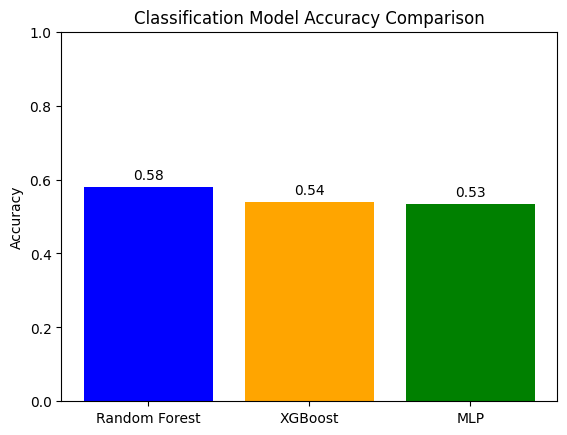

In [239]:
# Classification results visualization (full report)
models = ['Random Forest', 'XGBoost', 'MLP']
accuracies = [rf_clf_accuracy, xgb_clf_accuracy, mlp_clf_accuracy]
plt.bar(models, accuracies, color=['blue', 'orange', 'green'])
plt.ylabel('Accuracy')
plt.title('Classification Model Accuracy Comparison')
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
plt.show()

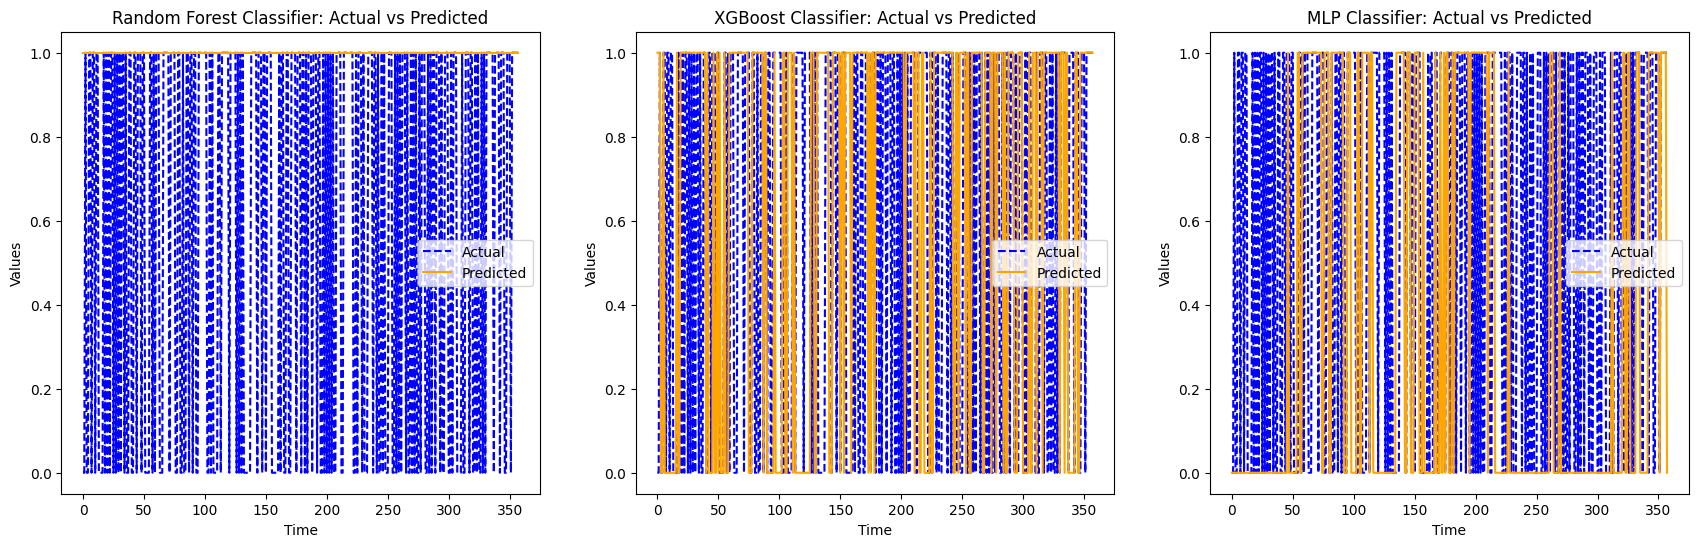

In [240]:
# Actual vs Predicted for Classification (line plot)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 6))
# random forest
ax1.plot(y_test_clf.values, label='Actual', color='blue', linestyle='--')
ax1.plot(y_pred_rf_clf, label='Predicted', color='orange')
ax1.set_title('Random Forest Classifier: Actual vs Predicted')
ax1.set_xlabel('Time')
ax1.set_ylabel('Values')
ax1.legend()

# xgboost
ax2.plot(y_test_clf.values, label='Actual', color='blue', linestyle='--')
ax2.plot(y_pred_xgb_clf, label='Predicted', color='orange')
ax2.set_title('XGBoost Classifier: Actual vs Predicted')
ax2.set_xlabel('Time')
ax2.set_ylabel('Values')
ax2.legend()

# MLP
ax3.plot(y_test_clf.values, label='Actual', color='blue', linestyle='--')
ax3.plot(y_pred_mlp_clf, label='Predicted', color='orange')
ax3.set_title('MLP Classifier: Actual vs Predicted')
ax3.set_xlabel('Time')
ax3.set_ylabel('Values')
ax3.legend()

plt.show()

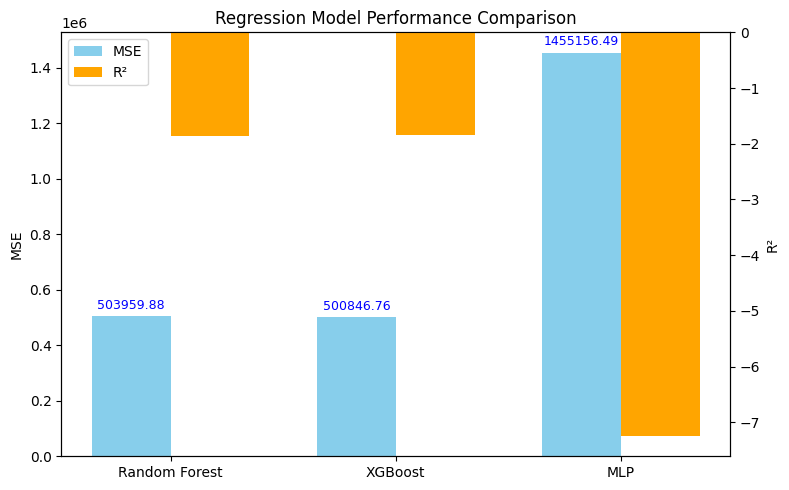

In [241]:
# Regression results visualization
import matplotlib.pyplot as plt
import numpy as np

# Collect metrics (keep your variable names)
regression_results = {
    "Random Forest": (rf_reg_mse, rf_reg_r2),
    "XGBoost": (xgb_reg_mse, xgb_reg_r2),
    "MLP": (mlp_reg_mse, mlp_reg_r2)
}

models = list(regression_results.keys())
mse_values = [v[0] for v in regression_results.values()]
r2_values = [v[1] for v in regression_results.values()]

fig, ax1 = plt.subplots(figsize=(8,5))
bar_width = 0.35
x = np.arange(len(models))

# MSE bars on left axis
bars1 = ax1.bar(x - bar_width/2, mse_values, width=bar_width, label='MSE', color='skyblue')
ax1.set_ylabel('MSE')
ax1.set_xticks(x)
ax1.set_xticklabels(models)

# R² bars on right axis
ax2 = ax1.twinx()
bars2 = ax2.bar(x + bar_width/2, r2_values, width=bar_width, label='R²', color='orange')
ax2.set_ylabel('R²')

# Add value labels for MSE (use ax1 coords and a small offset based on ax1 ylim)
ymin1, ymax1 = ax1.get_ylim()
offset1 = 0.01 * (ymax1 - ymin1)
for bar in bars1:
    h = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, h + offset1, f'{h:.2f}', ha='center', va='bottom', color='blue', fontsize=9)

# Add value labels for R² (use ax2 coords and offset based on ax2 ylim)
ymin2, ymax2 = ax2.get_ylim()
offset2 = 0.01 * (ymax2 - ymin2)
for bar in bars2:
    h = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, h + offset2, f'{h:.3f}', ha='center', va='bottom', color='orange', fontsize=9)

# Combined legend (merge handles from both axes)
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

plt.title('Regression Model Performance Comparison')
plt.tight_layout()
plt.show()



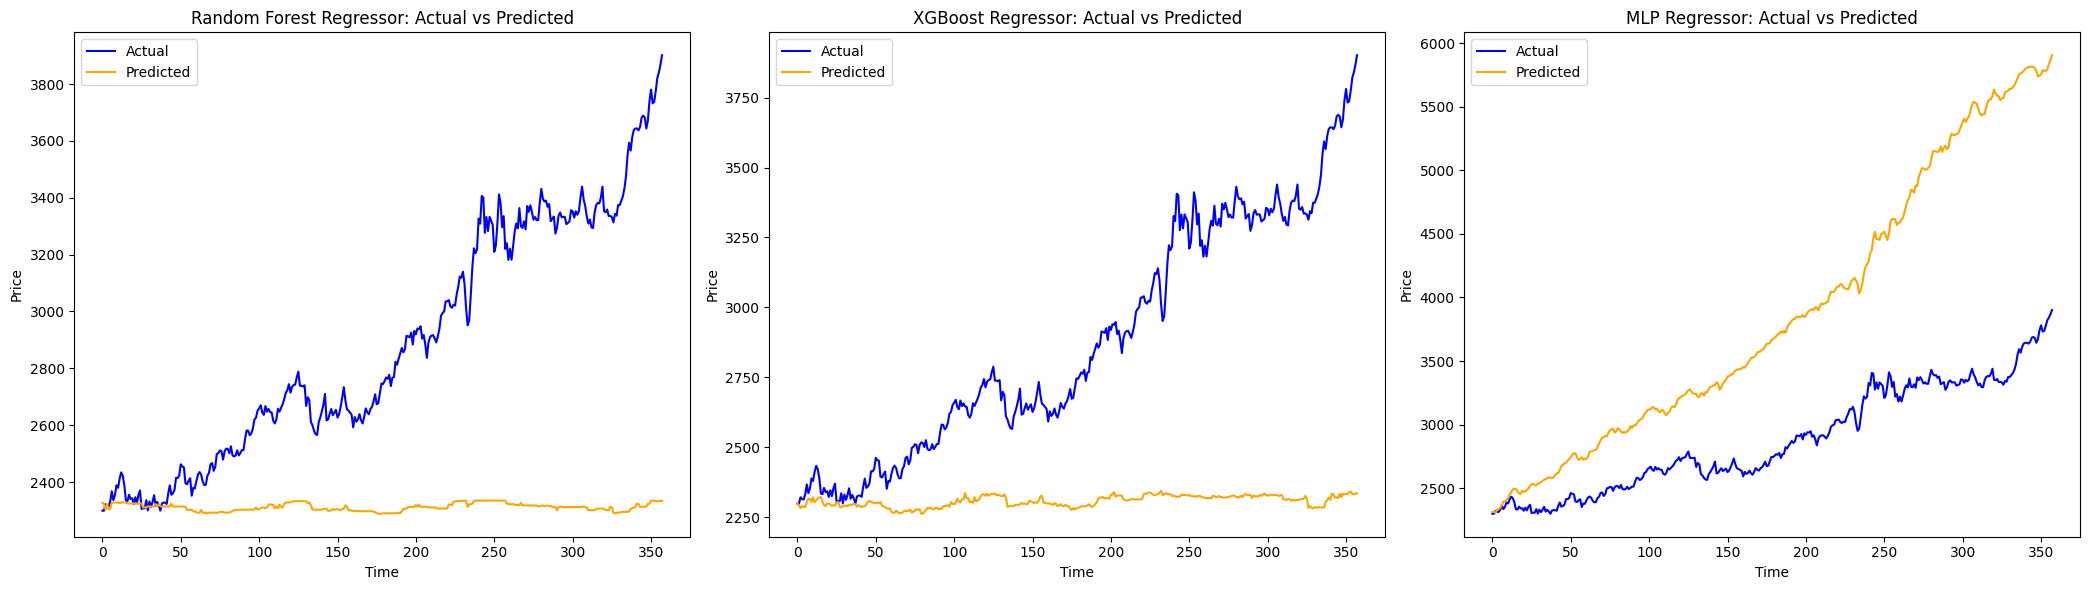

In [242]:
# Actual vs Predicted for Regression (date line plot)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 6))
# random forest
ax1.plot(y_test_reg.values, label='Actual', color='blue')
ax1.plot(y_pred_rf_reg, label='Predicted', color='orange')
ax1.set_title('Random Forest Regressor: Actual vs Predicted')
ax1.set_xlabel('Time')
ax1.set_ylabel('Price')
ax1.legend()

# xgboost
ax2.plot(y_test_reg.values, label='Actual', color='blue')
ax2.plot(y_pred_xgb_reg, label='Predicted', color='orange')
ax2.set_title('XGBoost Regressor: Actual vs Predicted')
ax2.set_xlabel('Time')
ax2.set_ylabel('Price')
ax2.legend()

# mlp
ax3.plot(y_test_reg.values, label='Actual', color='blue')
ax3.plot(y_pred_mlp_reg, label='Predicted', color='orange')
ax3.set_title('MLP Regressor: Actual vs Predicted')
ax3.set_xlabel('Time')
ax3.set_ylabel('Price')
ax3.legend()

plt.tight_layout()
plt.show()